In [1]:
# Yernar Shambayev, DL-2
# Обучить UNet сегментировать сгенерированные кружочки. Код для генерации тут:
# https://colab.research.google.com/drive/1Fum-Udmayf60qfJAl4N5z8hgUH6_uoTc

import torch
import torch.nn as nn
import numpy as np
from PIL import Image

In [2]:
class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

        
    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 10, border = 5, sigma = 20, rectangles=False):
    
    
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1
    
    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)
    
            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h
            
        label[mask, 2] = 1
        
        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))
    
    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    
    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb

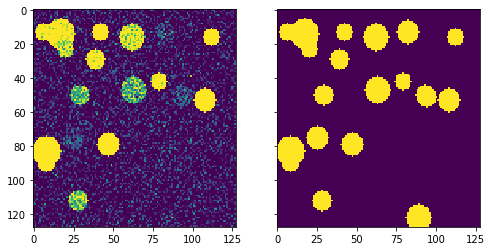

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

nx = 128
ny = 128

generator = RgbDataProvider(nx, ny, cnt=20)

x_test, y_test = generator(16)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [4]:
# Создаем Unet

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


def up_conv(in_channels, out_channels):
    return nn.ConvTranspose2d(
        in_channels, out_channels, kernel_size=2, stride=2
    )


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super().__init__()

        self.conv1 = double_conv(in_channels, 64)
        self.conv2 = double_conv(64, 128)
        self.conv3 = double_conv(128, 256)
        self.conv4 = double_conv(256, 512)
        self.bottleneck = double_conv(512, 1024)
        self.up_conv5 = up_conv(1024, 512)
        self.conv5 = double_conv(1024, 512)
        self.up_conv6 = up_conv(512, 256)
        self.conv6 = double_conv(512, 256)
        self.up_conv7 = up_conv(256, 128)
        self.conv7 = double_conv(256, 128)
        self.up_conv8 = up_conv(128, 64)
        self.conv8 = double_conv(128, 64)
        self.conv9 = nn.Conv2d(64, out_channels, kernel_size=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.sigmoid = nn.Sigmoid()

        self._weights_init()

    def _weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        conv1 = self.conv1(x)
        x = self.maxpool(conv1)

        conv2 = self.conv2(x)
        x = self.maxpool(conv2)

        conv3 = self.conv3(x)
        x = self.maxpool(conv3)

        conv4 = self.conv4(x)
        x = self.maxpool(conv4)

        bottleneck = self.bottleneck(x)

        x = self.up_conv5(bottleneck)
        x = torch.cat([x, conv4], dim=1)
        x = self.conv5(x)

        x = self.up_conv6(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.conv8(x)

        x = self.conv9(x)
        x = self.sigmoid(x)

        return x

In [5]:
# Обучаем нейросеть

model = UNet()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
loss = nn.BCELoss()
epochs = 30

for epoch in range(epochs):
    input = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2) # поменяем оси
    label = torch.from_numpy(y_test.astype(np.float32)).permute(0, 3, 1, 2)
    
    prediction = model(input)  
    l = loss(prediction, label)
    print(f'Эпоха: {epoch+1}, потери: {l.item()}')

    optim.zero_grad()
    l.backward()
    optim.step()

Эпоха: 1, потери: 2.771873712539673
Эпоха: 2, потери: 1.1845929622650146
Эпоха: 3, потери: 0.6868593096733093
Эпоха: 4, потери: 0.4609026312828064
Эпоха: 5, потери: 0.31914424896240234
Эпоха: 6, потери: 0.2331259846687317
Эпоха: 7, потери: 0.1875290423631668
Эпоха: 8, потери: 0.16421401500701904
Эпоха: 9, потери: 0.14891010522842407
Эпоха: 10, потери: 0.13442522287368774
Эпоха: 11, потери: 0.12013404071331024
Эпоха: 12, потери: 0.10845467448234558
Эпоха: 13, потери: 0.1006665974855423
Эпоха: 14, потери: 0.09613505005836487
Эпоха: 15, потери: 0.09340027719736099
Эпоха: 16, потери: 0.0910307765007019
Эпоха: 17, потери: 0.0882587730884552
Эпоха: 18, потери: 0.08459639549255371
Эпоха: 19, потери: 0.08046212792396545
Эпоха: 20, потери: 0.07674511522054672
Эпоха: 21, потери: 0.07328178733587265
Эпоха: 22, потери: 0.07163893431425095
Эпоха: 23, потери: 0.07060356438159943
Эпоха: 24, потери: 0.06506243348121643
Эпоха: 25, потери: 0.062045492231845856
Эпоха: 26, потери: 0.05874214693903923
Эпох